In [1]:
import os
import sys

import numpy as np
import cv2
from sklearn import linear_model

import lane_finding as lane
import lane_ransac as lransac

from lane_ransac import LanesRANSACRegressor

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = lane.calibration_parameters(path, cshape)

# Test calibration on some image.
filenames = os.listdir(path)
lane.test_calibration(path + filenames[11], cshape, mtx, dist)

Warning! Not chessboard found in image calibration1.jpg
Warning! Not chessboard found in image calibration4.jpg
Warning! Not chessboard found in image calibration5.jpg


Source points:
 [[  240.   720.]
 [  575.   460.]
 [  715.   460.]
 [ 1150.   720.]]
Destination points:
 [[  240.   720.]
 [  240.     0.]
 [ 1150.     0.]
 [ 1150.   720.]]
Perspective scaling: [ 0.044  0.01 ]


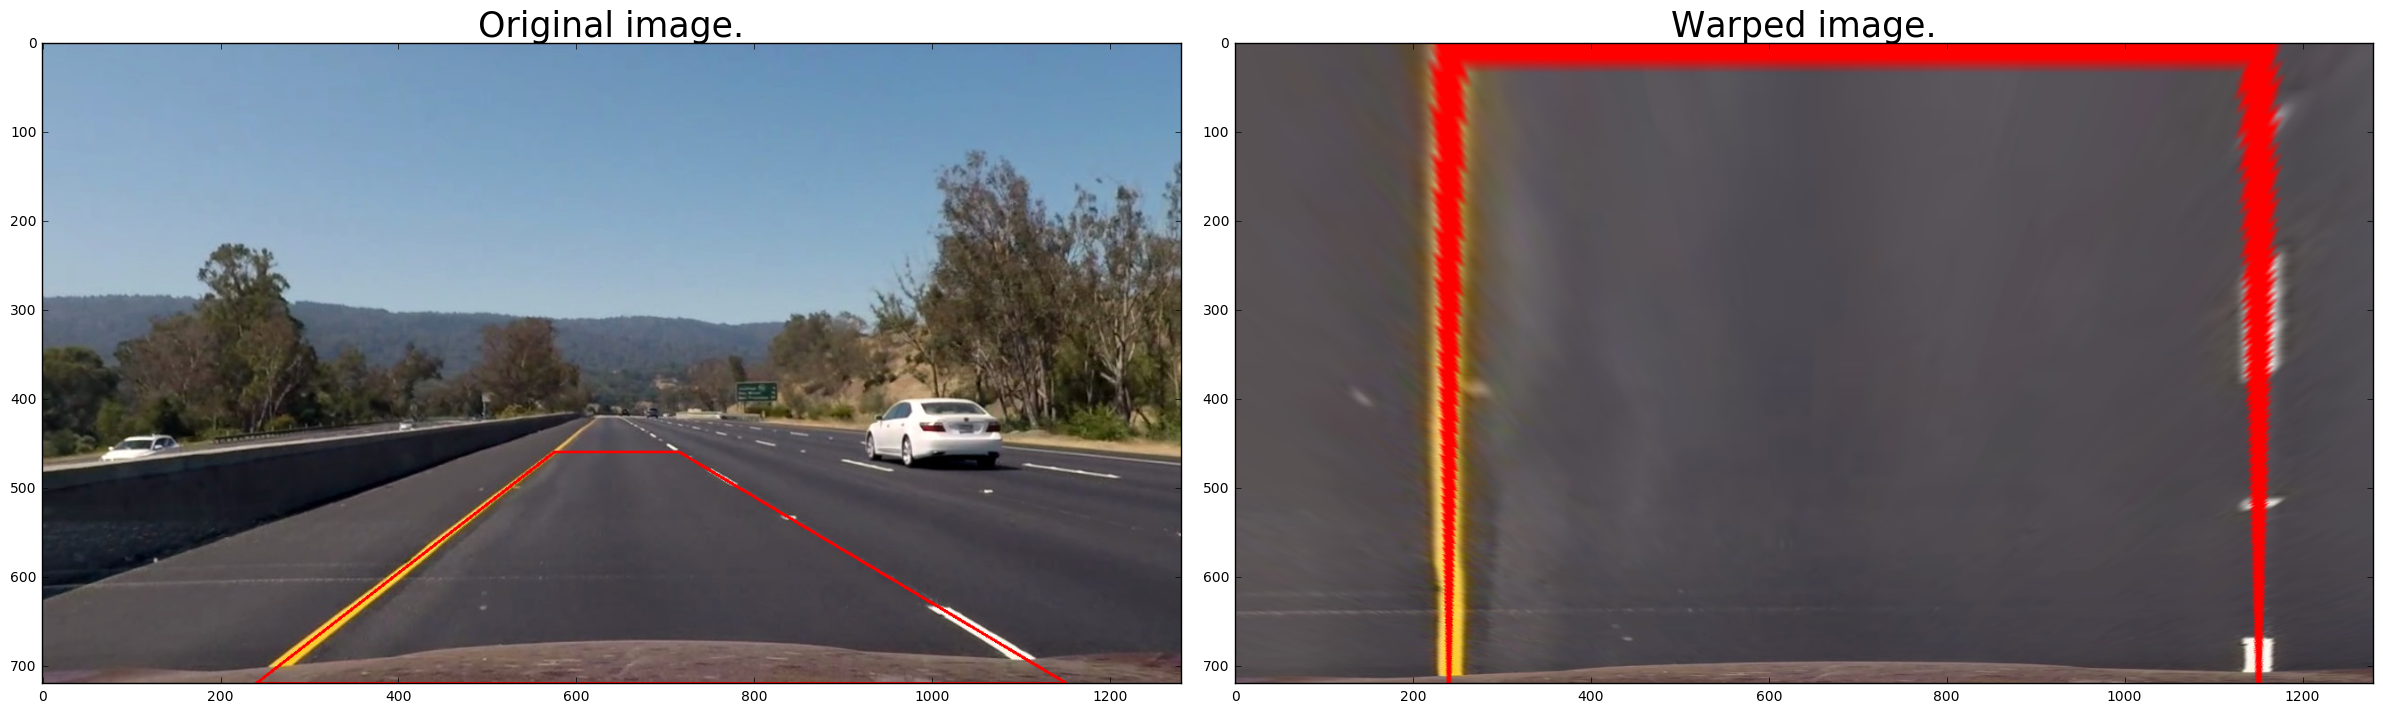

In [4]:
# Determine perspective transform.
fname = 'test_images/perspective.json'
src_points = lane.load_points(fname, 'src', dtype=np.float32)
dst_points = lane.load_points(fname, 'dst', dtype=np.float32)
perp_scaling = lane.load_points(fname, 'scaling', dtype=np.float32)
mtx_perp, mtx_perp_inv = lane.perspective_transform(src_points, dst_points)
print('Source points:\n', src_points)
print('Destination points:\n', dst_points)
print('Perspective scaling:', perp_scaling)

# Test the perspective transform.
fname = 'test_images/perspective.jpg'
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
lane.test_perspective(img, src_points, mtx_perp)

In [5]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def gradient_magnitude(gray, sobel_kernel=3):
    """Compute mask based on gradient magnitude. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Norm and rescaling (c.f. different kernel sizes)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_x(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6), iterations=3):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)
    
#     iterations=4
    mid=dilate_kernel[1] // 2
    # Dilate mask to the left.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.
    # Dilate mask to the right.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)
    
    # Eroding a bit
#     kernel = np.ones((1,2),np.uint8)
#     dmask = cv2.erode(dmask, kernel, iterations=5)
    return dmask
    

def mask_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask


def color_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask

In [6]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
print(filenames)

['perspective.jpg', 'perspective.json', 'signs_vehicles_xygrad.jpg', 'test (1).jpg', 'test (10).jpg', 'test (11).jpg', 'test (12).jpg', 'test (13).jpg', 'test (14).jpg', 'test (15).jpg', 'test (16).jpg', 'test (17).jpg', 'test (18).jpg', 'test (19).jpg', 'test (2).jpg', 'test (3).jpg', 'test (4).jpg', 'test (5).jpg', 'test (6).jpg', 'test (7).jpg', 'test (8).jpg', 'test (9).jpg', 'test1.jpg', 'test12.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


TEST on image: test_images/test (8).jpg (720, 1280, 3)


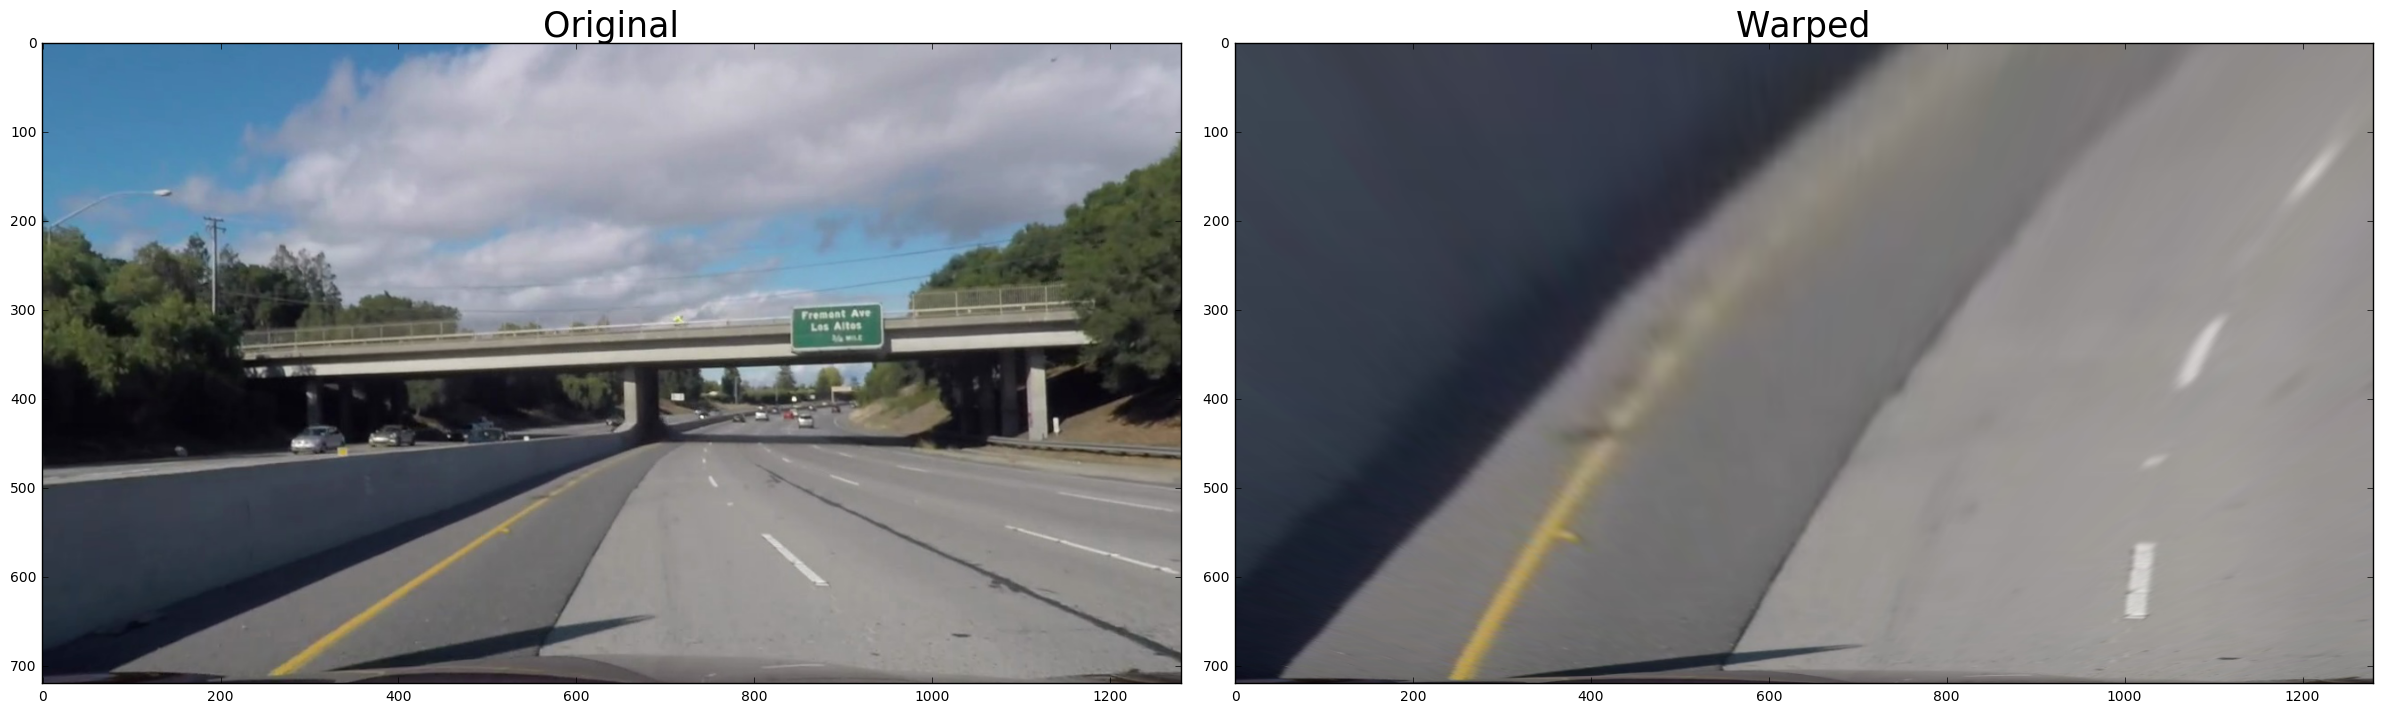

In [7]:
# Test on some image...
fname = path + os.listdir(path)[20]
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
# img = adjust_gamma(img, gamma=3.)
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
print('TEST on image:', fname, img.shape)

# Color spaces...
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Plot the bouzin!
lane.plot_images((img, wimg), ('Original', 'Warped'), figsize=(24, 9))
lane.plot_images((img_hsl[:, : , 0], img_hsl[:, : , 1], img_hsl[:, : , 2]), ('H', 'S', 'L'), figsize=(24, 9))

In [8]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def warped_masks(img, m_perp):
    """Generate a collection of masks for lines.
    Note: a collection can be useful to then compute weights.
    """
    # Grayscale and HSL.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Compute x gradients.
    skernel = 11
    sobel_dx = gradient_x(gray, sobel_kernel=skernel)
    s_sobel_dx = gradient_x(hsl[:, :, 2], sobel_kernel=skernel)
    # sobel_mag = gradient_magnitude(ungray, sobel_kernel=5)
    
    # Warped gradient fields.
#     wsobel_dx = cv2.warpPerspective(sobel_dx, m_perp, img_size, flags=cv2.INTER_LINEAR)
#     ws_sobel_dx = cv2.warpPerspective(s_sobel_dx, m_perp, img_size, flags=cv2.INTER_LINEAR)
    wsobel_dx = lane.warp_image(sobel_dx, m_perp, flags=cv2.INTER_LINEAR)
    ws_sobel_dx = lane.warp_image(s_sobel_dx, m_perp, flags=cv2.INTER_LINEAR)

    # Construct warped masks
    wmasks = []
    wmasks.append(mask_local_crossing_x(wsobel_dx, threshold=10, dilate_kernel=(1, 6), iterations=4))
    wmasks.append(mask_local_crossing_x(ws_sobel_dx, threshold=30, dilate_kernel=(1, 6), iterations=4))
    
#     img_blur = gaussian_blur(hsl[:,:,1], kernel_size=5)
#     edges = canny(img_blur, low_threshold=10, high_threshold=250)
#     wmasks.append(cv2.warpPerspective(edges, m_perp, img_size, flags=cv2.INTER_LINEAR))
        
#     img_blur = gaussian_blur(hsl[:,:,2], kernel_size=3)
#     edges = canny(img_blur, low_threshold=20, high_threshold=50)
#     wmasks.append(cv2.warpPerspective(edges, m_perp, img_size, flags=cv2.INTER_LINEAR))

    # masks.append(mask_threshold(sobel_mag, threshold=(50, 255)))
    # masks.append(mask_threshold(s_sobel_mag, threshold=(30, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    
    return wmasks

def default_left_right_masks(img, margin=0.1):
    """Default left and right masks used to find lanes: middle split with some additional margin.
    """
    shape = img.shape[0:2]
    llimit = int(shape[1] / 2 + shape[1] * margin)
    rlimit = int(shape[1] / 2 - shape[1] * margin)
    
    # Mask from meshgrid.
    xv, yv = np.mgrid[0:shape[0], 0:shape[1]]
    lmask = yv <= llimit
    rmask = yv >= rlimit
    
    return lmask, rmask


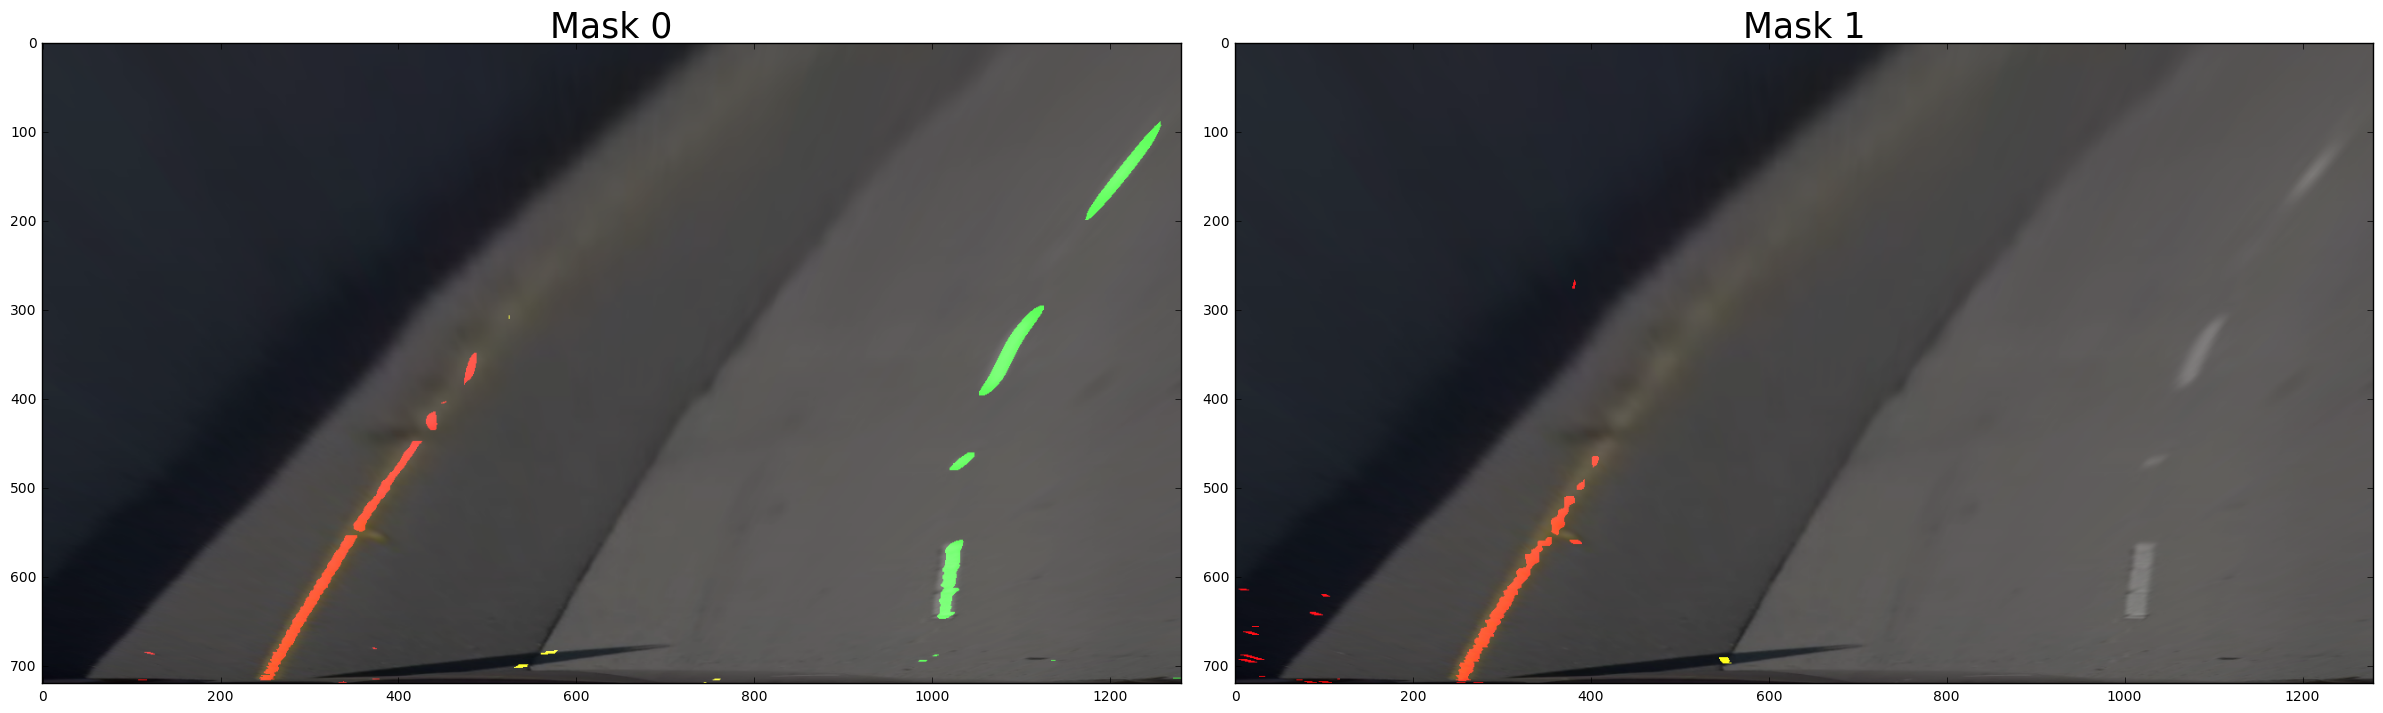

In [9]:
# Compute warped masks...
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

# Masks to plot...
wimgs = []
titles = []
for i, wm in enumerate(wmasks):
    mimg = lane.draw_mask(wimg, wm * lmask, alpha=0.6, beta=1., gamma=0., color=[255, 0, 0])
    mimg = lane.draw_mask(mimg, wm * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    wimgs.append(mimg)
    titles.append('Mask %i' % i)

lane.plot_images(wimgs, titles, figsize=(24, 9))

In [10]:
# from lane_ransac import LaneRANSACRegressor

wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

FLOAT_DTYPES = np.float64

def fit_ransac(wmasks, add_mask):
    """Fit a Ransac linear regression to masks points.
    """
    x = np.zeros((0,))
    y = np.zeros((0,))
    for wm in wmasks:
        # Perspective trick: construct points in initial space.
        # Avoid giving too much weights to background parts.
        x0, y0 = np.where(wm * add_mask)
        x = np.append(x, x0)
        y = np.append(y, y0)
        
    # Construct big vector! Assume order-2 model.
    X = np.zeros((len(x), 3), dtype=np.float32)
    X[:, 0] = 1.
    X[:, 1] = x
    X[:, 2] = x**2
   
    # Fit regression.
    res_threshold = 15
    max_trials = 1000
    mransac = linear_model.RANSACRegressor(linear_model.LinearRegression(), 
                                           residual_threshold=res_threshold, max_trials=max_trials)
    mransac.fit(X, y)
    
    return mransac, x, y


def warped_lane_mask(wimg, mransac_left, mransac_right):
    """Generate the lane mask based on left and right regression.
    """
    shape = wimg.shape[0:2]
    # Lines predictions.
    X = np.vstack((np.ones(shape[0], ), np.arange(0, shape[0]), np.arange(0, shape[0])**2)).T
    y_left = mransac_left.predict(X)
    y_right = mransac_right.predict(X)

    # Create an image to draw the lines on
    warp_zero = np.zeros(shape, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y_left, X[:, 1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([y_right, X[:, 1]])))])
    pts = np.hstack((pts_left, pts_right))
    
    pts = np.array([pts], dtype=np.int64)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0,255, 0))
    return color_warp

mransac_left, x_left, y_left = fit_ransac(wmasks, lmask)
mransac_right, x_right, y_right = fit_ransac(wmasks, rmask)

# Inlier / Outlier masks
inlier_mask_left = mransac_left.inlier_mask_
outlier_mask_left = np.logical_not(inlier_mask_left)
inlier_mask_right = mransac_right.inlier_mask_
outlier_mask_right = np.logical_not(inlier_mask_right)

# New prediction!
line_X_left = np.vstack((np.ones(720, ), np.arange(0, 720), np.arange(0, 720)**2)).T
line_y_left = mransac_left.predict(line_X_left)
line_y_right = mransac_right.predict(line_X_left)

# print(mransac_left.predict([0.0, 0.0, 0.0]))

wmask_lane = warped_lane_mask(wimg, mransac_left, mransac_right)

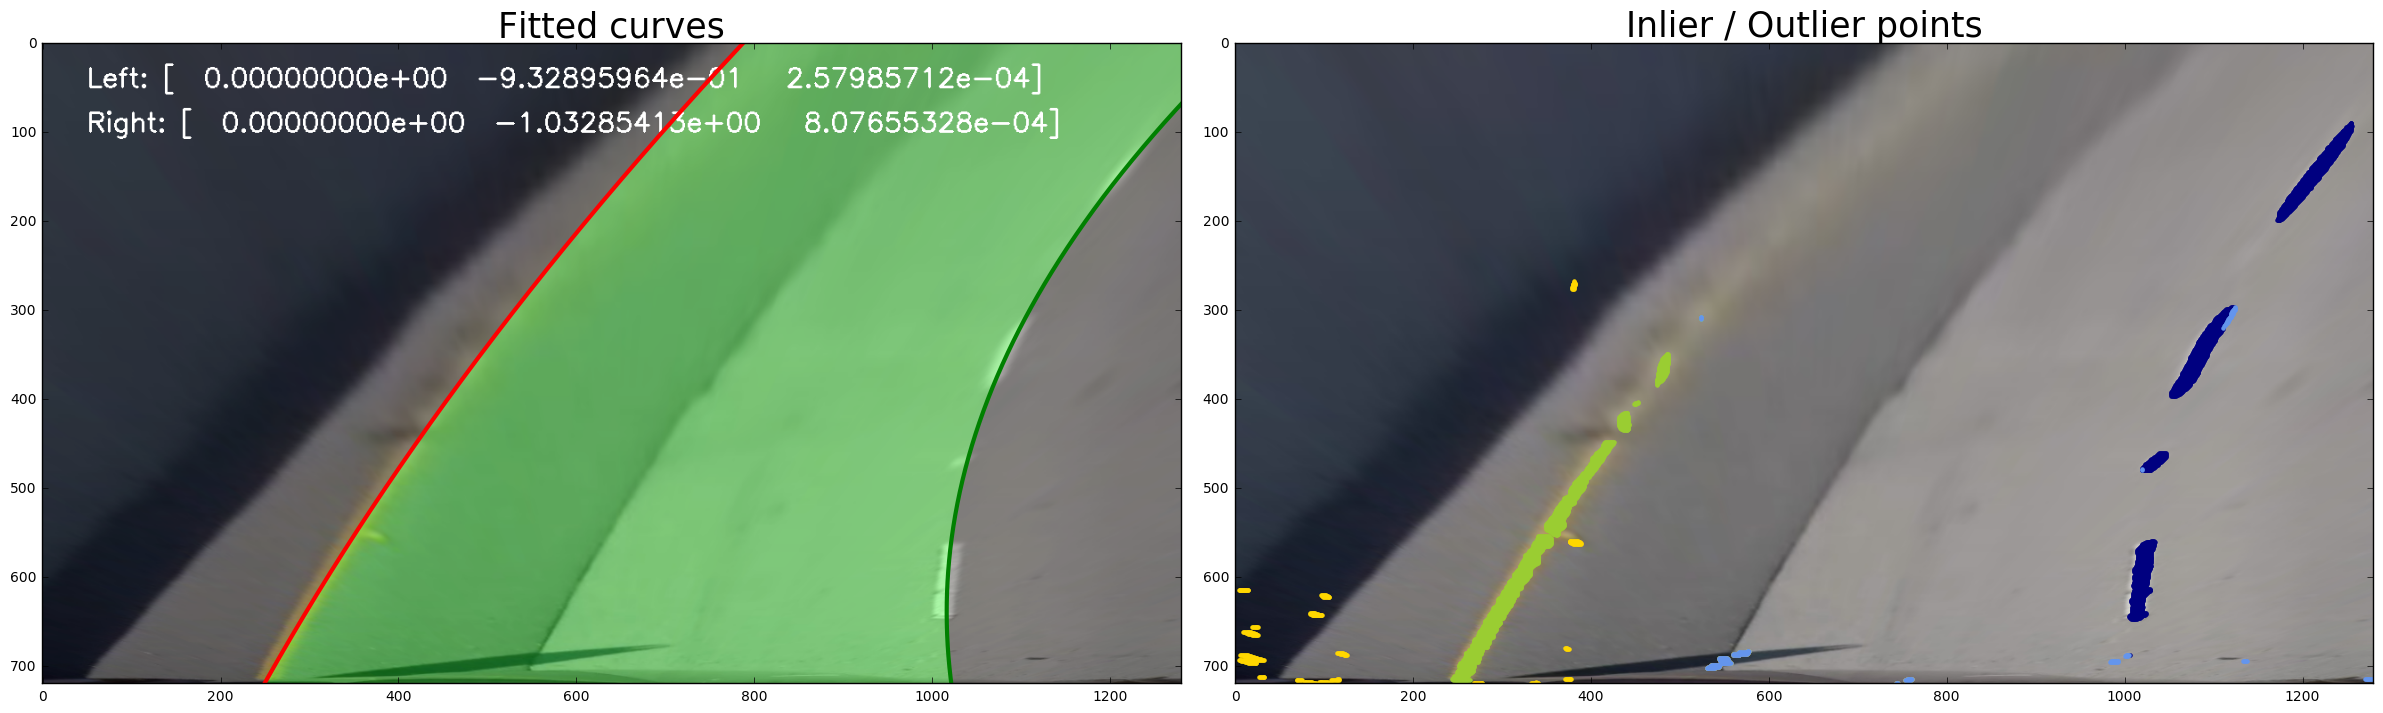

In [11]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(line_y_left, line_X_left[:, 1],  color='red', linestyle='-', linewidth=3)
ax1.plot(line_y_right, line_X_left[:, 1],  color='green', linestyle='-', linewidth=3)

wm_img = cv2.addWeighted(wimg, 0.8, wmask_lane, 0.3, 0.)
cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y_left[inlier_mask_left], x_left[inlier_mask_left], color='yellowgreen', marker='.')
plt.scatter(y_left[outlier_mask_left], x_left[outlier_mask_left], color='gold', marker='.')
plt.scatter(y_right[inlier_mask_right], x_right[inlier_mask_right], color='navy', marker='.', linewidth=1)
plt.scatter(y_right[outlier_mask_right], x_right[outlier_mask_right], color='cornflowerblue', marker='.', linewidth=1)
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

In [12]:
FLOAT_DTYPES = np.float64
from lane_ransac import LanesRANSACRegressor

# Warped image and masks
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

# Masks points.
X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

# Model validation bounds.
valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

valid_diffs[0, 0] = 0.6
valid_diffs[0, 1] = 0.8
valid_diffs[1, 1] = 0.4
valid_diffs[2, 1] = 0.3

# Fit regression.
res_threshold = 0.01
n_prefits = 1000
max_trials = 10000
lanes_ransac = LanesRANSACRegressor(residual_threshold=res_threshold, 
                                    is_valid_diffs=valid_diffs, 
                                    is_valid_bounds=valid_bounds,
                                    n_prefits=n_prefits,
                                    max_trials=max_trials)
lanes_ransac.fit(X1, y1, X2, y2)



LanesRANSACRegressor(is_valid_bounds=array([[[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]]]),
           is_valid_diffs=array([[ 0.6,  0.8],
       [ 0. ,  0.4],
       [ 0. ,  0.3]]),
           max_trials=10000, n_prefits=1000, random_state=None,
           residual_threshold=0.01, stop_n_inliers=inf,
           stop_probability=0.99, stop_score=inf)

In [13]:
# %prun -s cumulative lanes_ransac.fit(X1, y1, X2, y2)

In [14]:
X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
x_lane = X_lane[:, 1]

X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=False, normalise=False)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=False, normalise=False)
x1 = X1[:, 1]
x2 = X2[:, 1]

lane_wmask = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)

# Inlier / Outlier masks
inlier_mask1 = lanes_ransac.inlier_mask1_
outlier_mask1 = np.logical_not(inlier_mask1)
inlier_mask2 = lanes_ransac.inlier_mask2_
outlier_mask2 = np.logical_not(inlier_mask2)


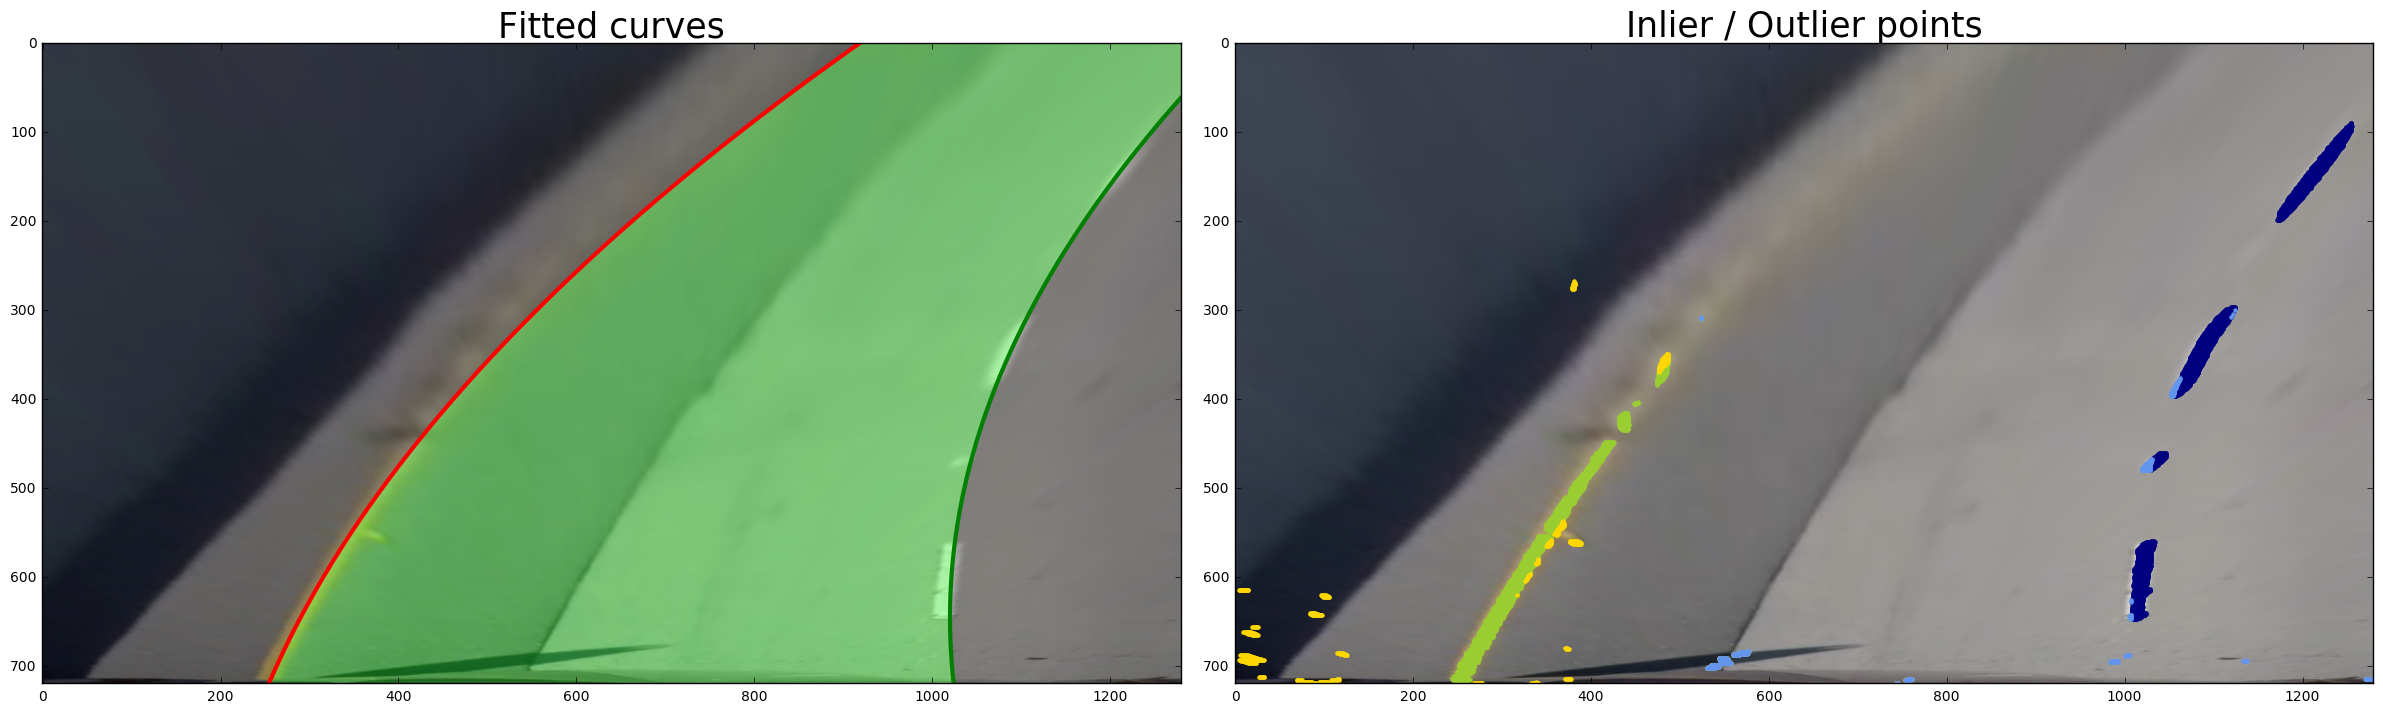

In [15]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(y1_lane, x_lane,  color='red', linestyle='-', linewidth=3)
ax1.plot(y2_lane, x_lane,  color='green', linestyle='-', linewidth=3)
wm_img = cv2.addWeighted(wimg, 0.8, lane_wmask, 0.3, 0.)
# cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
# cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y1[inlier_mask1], x1[inlier_mask1], color='yellowgreen', marker='.')
plt.scatter(y1[outlier_mask1], x1[outlier_mask1], color='gold', marker='.')
plt.scatter(y2[inlier_mask2], x2[inlier_mask2], color='navy', marker='.')
plt.scatter(y2[outlier_mask2], x2[outlier_mask2], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

143.41493841 127.549374326


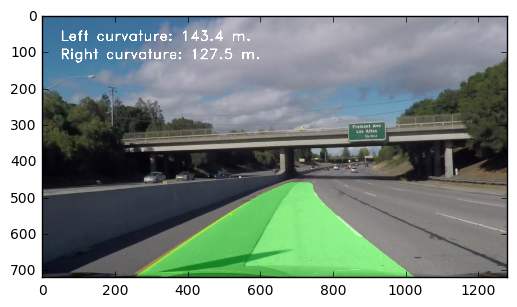

In [45]:
# Unwarp everything!
mask_lane = lane.warp_image(lane_wmask, mtx_perp_inv, flags=cv2.INTER_NEAREST)
mask_img = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

# Add curvature information.
curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))

cv2.putText(mask_img, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
cv2.putText(mask_img, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

print(curv_left, curv_right)
plt.imshow(mask_img)

In [17]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

In [51]:
# Full pipeline on test images.
path = 'test_images/'
# path = 'test_images_kyle/'
path_save = 'debug/'
filenames = os.listdir(path)
for fname in filenames:
    print('Processing image: ', fname)
    img_name = fname[:-4]
    img = lane.undistort_image(lane.load_image(path + fname), mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = warped_masks(img, mtx_perp)
    lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # DEBUG save.
    masked_img = lane.draw_mask(wimg, wmasks[0] * lmask, alpha=0.5, beta=1., gamma=0., color=[255, 0, 0])
    masked_img = lane.draw_mask(masked_img, wmasks[0] * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask0.jpg', masked_img)
    masked_img = lane.draw_mask(wimg, wmasks[1] * lmask, alpha=0.5, beta=1., gamma=0., color=[255, 0, 0])
    masked_img = lane.draw_mask(masked_img, wmasks[1] * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask1.jpg', masked_img)

    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

    # Model validation bounds.
    valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
    valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

    valid_diffs[0, 0] = 0.6
    valid_diffs[0, 1] = 0.8
    valid_diffs[1, 1] = 0.4
    valid_diffs[2, 1] = 0.3

    # Fit regression.
    res_threshold = 0.01
    n_prefits = 1000
    max_trials = 10000
    lanes_ransac = LanesRANSACRegressor(residual_threshold=res_threshold, 
                                        is_valid_diffs=valid_diffs, 
                                        is_valid_bounds=valid_bounds,
                                        n_prefits=n_prefits,
                                        max_trials=max_trials)
    lanes_ransac.fit(X1, y1, X2, y2)
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    wimg_lane = cv2.addWeighted(wimg, 0.9, wmask_lane, 0.4, 0.)
    
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

    # Add curvature information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    # Save images.
    mpimg.imsave(path_save+img_name+'_wlane.jpg', wimg_lane)
    mpimg.imsave(path_save+img_name+'_lane.jpg', img_lane)
    


Processing image:  signs_vehicles_xygrad.jpg
Processing image:  test (1).jpg
Processing image:  test (10).jpg
Processing image:  test (11).jpg
Processing image:  test (12).jpg
Processing image:  test (13).jpg
Processing image:  test (14).jpg
Processing image:  test (15).jpg
Processing image:  test (16).jpg
Processing image:  test (17).jpg
Processing image:  test (18).jpg
Processing image:  test (19).jpg
Processing image:  test (2).jpg
Processing image:  test (3).jpg
Processing image:  test (4).jpg
Processing image:  test (5).jpg
Processing image:  test (6).jpg
Processing image:  test (7).jpg
Processing image:  test (8).jpg
Processing image:  test (9).jpg
Processing image:  test1.jpg
Processing image:  test12.jpg
Processing image:  test2.jpg
Processing image:  test3.jpg
Processing image:  test4.jpg
Processing image:  test5.jpg
Processing image:  test6.jpg


In [53]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_image(img_orig):
    img = lane.undistort_image(img_orig, mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = warped_masks(img, mtx_perp)
    lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

    # Model validation bounds.
    valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
    valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

    valid_diffs[0, 0] = 0.6
    valid_diffs[0, 1] = 0.8
    valid_diffs[1, 1] = 0.4
    valid_diffs[2, 1] = 0.3

    # Fit regression.
    res_threshold = 0.01
    n_prefits = 1000
    max_trials = 10000
    lanes_ransac = LanesRANSACRegressor(residual_threshold=res_threshold, 
                                        is_valid_diffs=valid_diffs, 
                                        is_valid_bounds=valid_bounds,
                                        n_prefits=n_prefits,
                                        max_trials=max_trials)
    lanes_ransac.fit(X1, y1, X2, y2)
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    # Add curvature information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    return img_lane
    


In [54]:
white_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:01<00:00,  2.02it/s]  0%|                                                                                 | 1/1261 [00:00<10:34,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

Wall time: 13min 4s


In [ ]:
white_output = 'challenge_video_lane.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_lane.mp4
[MoviePy] Writing video challenge_video_lane.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [05:51<00:00,  2.06it/s]  0%|▏                                                                                 | 1/485 [00:00<03:44,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_lane.mp4 

Wall time: 5min 53s


In [ ]:
white_output = 'harder_challenge_video_lane.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_lane.mp4
[MoviePy] Writing video harder_challenge_video_lane.mp4


 14%|██████████▍                                                                  | 163/1200 [08:40<9:32:45, 33.14s/it]  0%|                                                                                 | 1/1200 [00:00<19:05,  1.05it/s]